In [1]:
source('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R')
source('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_visuals.R')
source('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/cdr3_functions.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract



Attaching package: ‘arrow’


The following object is masked from ‘package:magrittr’:

    is_in


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: dtplyr

Loading required package: patchwork


Attaching package: ‘DescTools’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following o

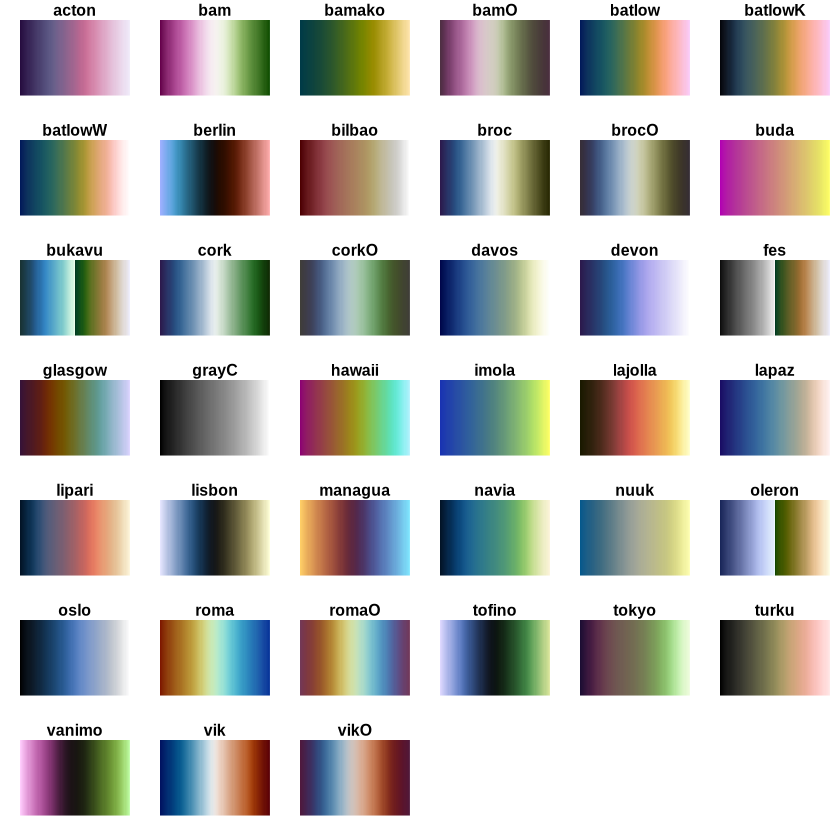

In [ ]:
scico::scico_palette_show()

## Cluster all HLA alleles based on cdr3QTL patterns

### this chunk when using HLA alleles from our population

In [ ]:
hla_var <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/all_hla_variations_long.tsv')
phenotype <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/phenotypes.tsv')
hla_var <- merge(hla_var, phenotype, by = 'patient_id')

### this chunk when using all HLA alleles from IMGT database

In [159]:
hla_var <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/reference_data/hla_msa/DRB1_long.tsv')
setnames(hla_var, old = 'site', new = 'Site_hla')
hla_var[, Site_hla := paste0(strsplit(allele, '\\*')[[1]][1], '_', Site_hla)]

In [160]:
hla_freq_caucasian <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/reference_data/hla_drb1_freq_caucasian.csv')[
    Population == 'Germany DKMS - German donors'][
    Allele_freq > 0, c('Allele', 'Allele_freq')]
setnames(hla_freq_caucasian, old = 'Allele', new = 'allele')
common_hla_alleles <- unique(hla_freq_caucasian$allele)

In [ ]:
head(hla_freq_caucasian)

allele,Allele_freq
<chr>,<dbl>
DRB1*01:01,0.0965
DRB1*01:02,0.0104
DRB1*01:03,0.0031
DRB1*01:07,0.0001
DRB1*03:01,0.1067
DRB1*03:02,0.0002


In [161]:
cdr3qtls <- c('DRB1_13', 'DRB1_32', 'DRB1_37', 'DRB1_67', 'DRB1_71', 'DRB1_86')
hla_var <- hla_var[Site_hla %in% cdr3qtls][allele %in% common_hla_alleles]
hla_var <- merge(hla_var, hla_freq_caucasian, by = 'allele')

In [162]:
hla_var_patterns <- hla_var[, .(cdr3qtl_pattern = paste0(AA, collapse = ''), Allele_freq = unique(Allele_freq)), 
    by = .(allele)][, .(allele = paste0(allele,collapse = '\n'), Allele_freq = sum(Allele_freq)), by = cdr3qtl_pattern] 
allele_ids <- hla_var_patterns$allele
pattern_sequences <- hla_var_patterns$cdr3qtl_pattern

allele_ids_with_sizes <- data.frame(
  name = hla_var_patterns$allele,  # Node names
  size = sqrt(hla_var_patterns$Allele_freq)*100       # Node sizes (frequencies or other values)
)

In [9]:
head(hla_var_patterns)

allele,cdr3qtl_pattern,Allele_freq
<chr>,<chr>,<dbl>
DRB1*01:01,FYSLRG,0.0965
DRB1*01:02,FYSLRV,0.0104
DRB1*01:03,FYSIEG,0.0031
DRB1*01:07,FYSLRG,0.0001
DRB1*03:01,SHNLKV,0.1067
DRB1*03:02,SHNLKG,0.0002


## Building Hamming distance and plot them as network

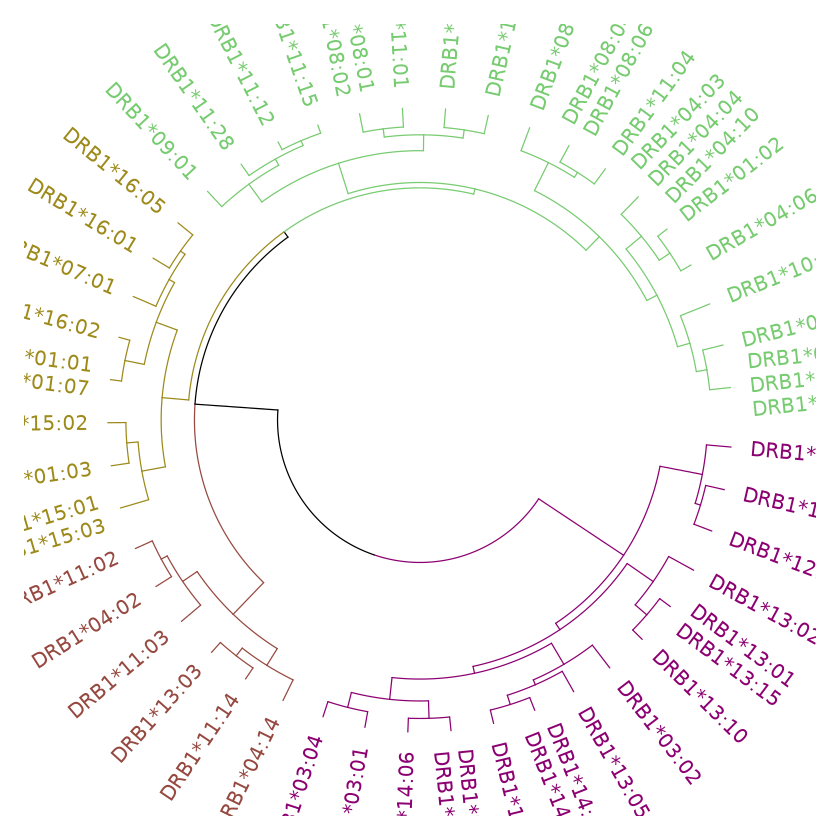

In [ ]:
hamming_distance_matrix <- stringdistmatrix(pattern_sequences, method = "hamming")
hamming_distance_matrix_full <- as.matrix(hamming_distance_matrix)
colnames(hamming_distance_matrix_full) <- allele_ids
rownames(hamming_distance_matrix_full) <- allele_ids
hclust_hamming <- hclust(dist(hamming_distance_matrix_full), method = "ward.D2")
dend <- as.dendrogram(hclust_hamming)
num_clusters <- 4
cluster_labels <- cutree(hclust_hamming, k = num_clusters)

cluster_colors <- scico(n = num_clusters, palette = 'hawaii', end = 0.7)

dend <- color_labels(dend, k = num_clusters, col = cluster_colors)  # Color labels by clusters
dend <- color_branches(dend, k = num_clusters, col = cluster_colors)  # Color branches by clusters
dend <- set(dend, "labels_cex", 1)  # Adjust label size

circlize_dendrogram(dend)


In [ ]:
# Plot circular dendrogram
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/circular_dendrogram_hamming.pdf", 
    width = 12, height = 12)
circlize_dendrogram(dend)
# Plot the dendrogram
#plot(hclust_hamming,
#     main = "Hierarchical Clustering of Alleles (Hamming Distance)",
#     xlab = "Alleles",
#     ylab = "Hamming Distance")
dev.off()

agg_record_303079646 
                   2

## Network of Hamming

In [ ]:
hamming_threshold_for_edges <- 1
edges_dt_hamming_network <- data.table(melt(hamming_distance_matrix_full))[, 
  Var1 := as.character(Var1)][,
  Var2 := as.character(Var2)][, pair := paste0(pmin(Var1,Var2), pmax(Var1,Var2))][Var1 != Var2][
  value <= hamming_threshold_for_edges][!duplicated(pair)][, pair := NULL]
setnames(edges_dt_hamming_network, new =c('from', 'to', 'weight'), old = c('Var1', 'Var2', 'value')) 

In [ ]:
g_hamming_network <- graph_from_data_frame(d = edges_dt_hamming_network,
                                           vertices = allele_ids_with_sizes, # Ensure all alleles are nodes
                                           directed = FALSE)

# Add cluster membership and original pattern sequences as node attributes
V(g_hamming_network)$label <- V(g_hamming_network)$name
V(g_hamming_network)$cluster <- as.numeric(cluster_labels[V(g_hamming_network)$name])
V(g_hamming_network)$pattern <- hla_var_patterns$cdr3qtl_pattern[match(V(g_hamming_network)$name, hla_var_patterns$allele)]
 # Set allele ID as label

# Set node colors based on cluster membership
cluster_colors <- scico(4, palette = 'hawaii', end = 0.7, alpha = 0.5)

V(g_hamming_network)$color <- cluster_colors[V(g_hamming_network)$cluster]

# Plot the network
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hamming_distance_network_all_hla_alleles.pdf", width = 10, height = 10)
plot(g_hamming_network,
     vertex.label = V(g_hamming_network)$label, # Show allele ID
     vertex.label.cex = 0.8,
     vertex.color = cluster_colors[V(g_hamming_network)$cluster],
     vertex.size = ifelse(V(g_hamming_network)$size > 5, V(g_hamming_network)$size, 5), # Adjust as needed
     edge.width = E(g_hamming_network)$weight * 5,
     edge.color = "gray70",
     layout = layout_with_fr(g_hamming_network), # A good default layout
     main = "Allele Similarity Network (Hamming Distance)")
dev.off()

agg_record_1961080619 
                    2

## Cluster them based on their chemical properties

In [163]:
aa_properties <- data.table(
  AA = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'),
  Hydrophobicity = c(1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8, -0.7, -0.9, -1.3, 4.2), # Kyte-Doolittle
  Polarity = c(8.1, 10.5, 11.6, 13.0, 5.5, 10.5, 12.3, 8.3, 10.4, 5.2, 4.9, 11.3, 5.7, 5.2, 8.0, 9.2, 8.6, 5.4, 6.2, 5.9), # Grantham's polarity
  Volume = c(67, 124, 96, 97, 86, 114, 109, 48, 118, 124, 124, 135, 124, 135, 90, 73, 93, 163, 141, 84) # Grantham's molecular volume
)

# Set AA as key for fast lookup
setkey(aa_properties, AA)

In [ ]:
head(aa_properties)

AA,Hydrophobicity,Polarity,Volume
<chr>,<dbl>,<dbl>,<dbl>
A,1.8,8.1,67
C,2.5,5.5,86
D,-3.5,13.0,97
E,-3.5,12.3,109
F,2.8,5.2,135
G,-0.4,8.3,48


In [164]:
sequence_length <- length(cdr3qtls)
num_properties <- ncol(aa_properties) - 1 # Exclude 'AA' column
physchem_matrix <- matrix(NA, nrow = length(allele_ids), ncol = sequence_length * num_properties)
rownames(physchem_matrix) <- allele_ids

# Loop through each allele and its sequence
for (i in 1:length(allele_ids)) {
  seq <- pattern_sequences[i]
  aas <- str_split(seq, "")[[1]] # Split sequence into individual amino acids

  # Check if all amino acids in the sequence are in our property lookup table
  if (!all(aas %in% aa_properties$AA)) {
    stop(paste("Sequence for allele", allele_ids[i], "contains unknown amino acids. Please check your data or expand 'aa_properties' table."))
  }

  feature_vector_for_seq <- c()
  for (aa in aas) {
    # Extract properties for the current amino acid
    props <- as.numeric(aa_properties[aa, -1]) # Exclude AA column, convert to numeric
    feature_vector_for_seq <- c(feature_vector_for_seq, props)
  }
  physchem_matrix[i, ] <- feature_vector_for_seq
}

print(head(physchem_matrix, 2))

                       [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
DRB1*01:01\nDRB1*01:07  2.8  5.2  135 -1.3  6.2  141 -0.8  9.2   73   3.8   4.9
DRB1*01:02              2.8  5.2  135 -1.3  6.2  141 -0.8  9.2   73   3.8   4.9
                       [,12] [,13] [,14] [,15] [,16] [,17] [,18]
DRB1*01:01\nDRB1*01:07   124  -4.5  10.5   124  -0.4   8.3    48
DRB1*01:02               124  -4.5  10.5   124   4.2   5.9    84


In [165]:
physchem_distance_matrix <- dist(physchem_matrix, method = "euclidean")

# Convert to a full matrix for inspection
physchem_distance_matrix_full <- as.matrix(physchem_distance_matrix)
colnames(physchem_distance_matrix_full) <- allele_ids
rownames(physchem_distance_matrix_full) <- allele_ids

head(physchem_distance_matrix_full)

,DRB1*01:01 DRB1*01:07,DRB1*01:02,DRB1*01:03,DRB1*03:01,DRB1*03:02,DRB1*03:04,DRB1*04:01,DRB1*04:02,DRB1*04:03 DRB1*04:04 DRB1*04:10,DRB1*04:05 DRB1*04:07 DRB1*04:08,⋯,DRB1*13:10,DRB1*14:02 DRB1*14:03,DRB1*14:04,DRB1*14:06,DRB1*14:07,DRB1*15:01 DRB1*15:03,DRB1*15:02,DRB1*16:01,DRB1*16:02,DRB1*16:05
DRB1*01:01 DRB1*01:07,0.00000,36.37197,15.15982,80.06360,71.32503,76.60372,71.46531,80.85809,79.42424,70.60659,⋯,80.0672218,70.46460,115.47718,79.29805,91.08331,69.42860,59.13890,18.01305,14.22603,14.24640
DRB1*01:02,36.37197,0.00000,39.40482,71.32503,80.06360,67.41817,80.18859,72.21572,70.60659,79.42424,⋯,71.3290964,79.29805,109.59954,70.46460,98.07696,59.13890,69.42860,40.58805,39.05509,39.06251
DRB1*01:03,15.15982,39.40482,0.00000,83.46209,75.11990,80.14905,75.25311,79.42424,80.85809,72.21572,⋯,83.4586125,72.07690,116.46802,80.73413,92.33629,57.74972,44.85655,23.56926,20.78942,20.77547
DRB1*03:01,80.06360,71.32503,83.46209,0.00000,36.37197,23.28197,77.22933,72.93278,69.01775,78.01519,⋯,0.7615773,38.01210,48.47288,11.04536,55.19574,91.52043,98.48304,72.63395,71.78858,71.79262
DRB1*03:02,71.32503,80.06360,75.11990,36.37197,0.00000,43.18530,68.12819,81.49914,78.01519,69.01775,⋯,36.3799395,11.04536,60.60149,38.01210,41.51686,98.48304,91.52043,62.87106,61.89249,61.89717
DRB1*03:04,76.60372,67.41817,80.14905,23.28197,43.18530,0.00000,92.40465,88.84503,85.66038,93.06245,⋯,23.2944199,44.57544,67.97742,25.76917,72.92380,88.50955,95.69148,68.80145,67.90839,67.91266


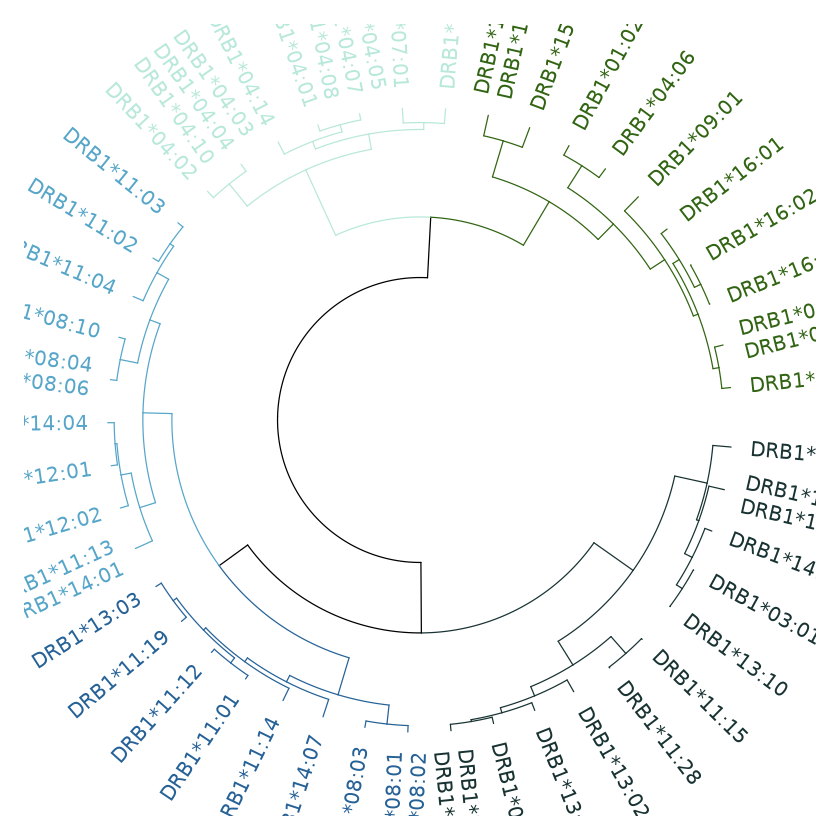

In [ ]:
hclust_physchem <- hclust(physchem_distance_matrix, method = "ward.D2")

# Cut the dendrogram to define clusters (e.g., 3 clusters)
num_clusters_physchem <- 6
clusters_physchem <- cutree(hclust_physchem, k = num_clusters_physchem)

# Enhance the dendrogram with colors
dend_physchem <- as.dendrogram(hclust_physchem)
physchem_colors <- scico(num_clusters_physchem, palette = 'bukavu', end = 0.6)
dend_physchem <- color_branches(dend_physchem, k = num_clusters_physchem, col = physchem_colors)
dend_physchem <- color_labels(dend_physchem, k = num_clusters_physchem, col = physchem_colors)
circlize_dendrogram(dend_physchem)

In [ ]:
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/circular_dendrogram_psyschem.pdf", 
    width = 12, height = 12)
circlize_dendrogram(dend_physchem)
dev.off()

agg_record_618933751 
                   2

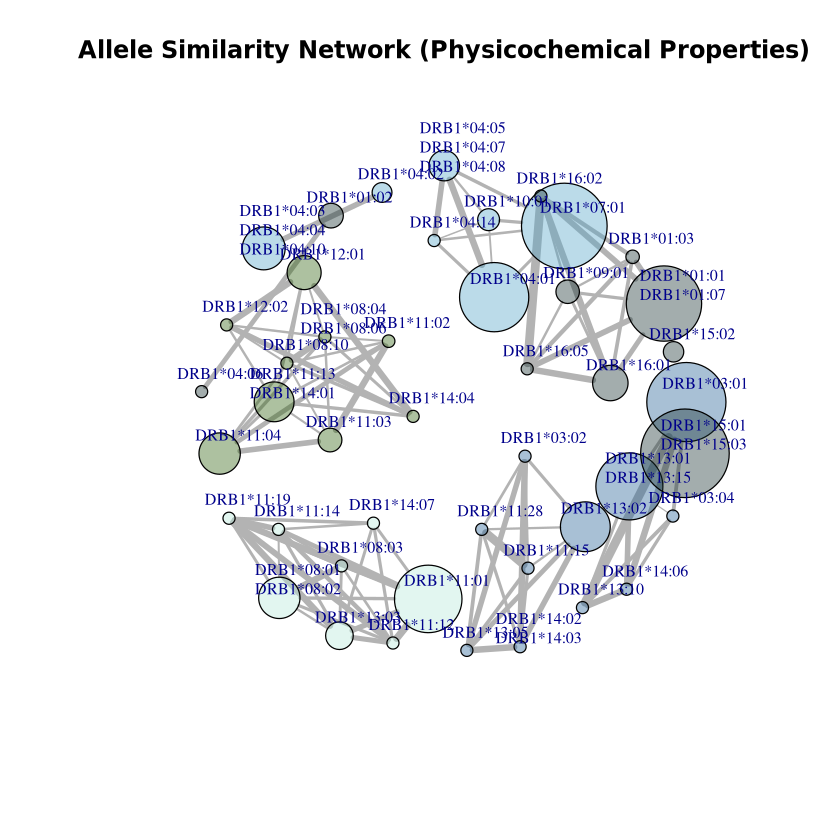

In [171]:
physchem_threshold_for_edges <- 35 # Example threshold, adjust based on your data's distance range

edges_dt_physchem_network <- data.table(melt(physchem_distance_matrix_full))[, 
  Var1 := as.character(Var1)][,
  Var2 := as.character(Var2)][, pair := paste0(pmin(Var1,Var2), pmax(Var1,Var2))][Var1 != Var2][
  value <= physchem_threshold_for_edges][!duplicated(pair)][, pair := NULL][,
  weight:= max(value) - value + min(value)]
setnames(edges_dt_physchem_network, new =c('from', 'to'), old = c('Var1', 'Var2')) 
edges_dt_physchem_network$weight <- scales::rescale(edges_dt_physchem_network$weight, to = c(1, 7))

# Create the igraph object
g_physchem_network <- graph_from_data_frame(d = edges_dt_physchem_network,
                                            vertices = allele_ids_with_sizes,
                                            directed = FALSE)

# Add cluster membership and pattern sequences as node attributes
V(g_physchem_network)$cluster <- clusters_physchem[V(g_physchem_network)$name]
V(g_physchem_network)$pattern <- hla_var_patterns$cdr3qtl_pattern[match(V(g_physchem_network)$name, hla_var_patterns$allele)]
V(g_physchem_network)$label <- V(g_physchem_network)$name
E(g_physchem_network)$weight <- edges_dt_physchem_network$weight

# Set node colors based on cluster membership
physchem_colors <- scico(num_clusters_physchem, palette = 'bukavu', end = 0.6, alpha = 0.4)
V(g_physchem_network)$color <- physchem_colors[as.numeric(V(g_physchem_network)$cluster)]

write_graph(g_physchem_network, file = "/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/graphs/hla_drb1_graph.graphml", format = "graphml")

plot(g_physchem_network,
      vertex.label = V(g_physchem_network)$label,
      vertex.label.cex = 0.8,
      vertex.label.dist = 1.5, 
      vertex.color = V(g_physchem_network)$color,
      vertex.size = ifelse(V(g_physchem_network)$size > 5, V(g_physchem_network)$size, 5),
      edge.width = E(g_physchem_network)$weight,
      edge.color = "gray70",
      layout = layout_with_kk(g_physchem_network, weights = E(g_physchem_network)$weight),
      main = "Allele Similarity Network (Physicochemical Properties)")

null device 
          1

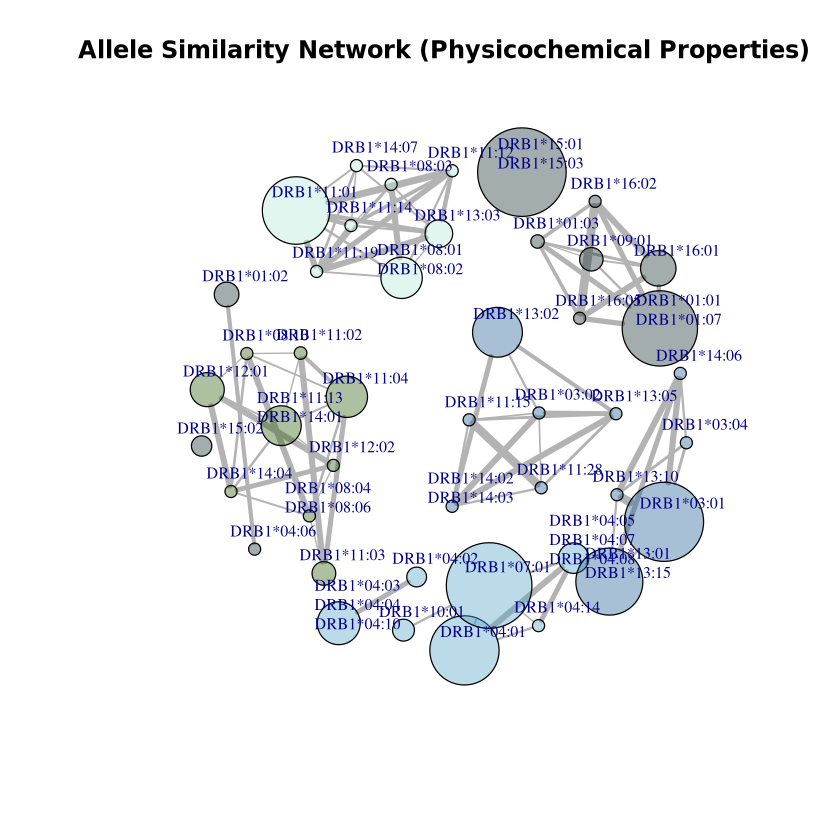

In [ ]:
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/allele_network_physchem_clusters.pdf", width = 10, height = 8)
plot(g_physchem_network,
      vertex.label = V(g_physchem_network)$label,
      vertex.label.cex = 0.8,
      vertex.label.dist = 1.5, 
      vertex.color = V(g_physchem_network)$color,
      vertex.size = ifelse(V(g_physchem_network)$size > 5, V(g_physchem_network)$size, 5),
      edge.width = E(g_physchem_network)$weight,
      edge.color = "gray70",
      layout = layout_with_kk(g_physchem_network, weights = E(g_physchem_network)$weight),
      main = "Allele Similarity Network (Physicochemical Properties)")
dev.off()

## The same for HLA-B

In [126]:
hla_var <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/reference_data/hla_msa/B_long.tsv')
setnames(hla_var, old = 'site', new = 'Site_hla')
hla_var[, Site_hla := paste0(strsplit(allele, '\\*')[[1]][1], '_', Site_hla)]
hla_freq_caucasian <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/reference_data/hla_b_freq_caucasian.csv')[
    Population == 'Germany DKMS - German donors'][
    Allele_freq > 0.0001, c('Allele', 'Allele_freq')]
setnames(hla_freq_caucasian, old = 'Allele', new = 'allele')
common_hla_alleles <- unique(hla_freq_caucasian$allele)

In [127]:
cdr3qtls <- c('B_9', 'B_45', 'B_67', 'B_80', 'B_114', 'B_156', 'B_171')
#cdr3qtls <- c( 'B_45', 'B_67', 'B_80', 'B_114', 'B_156')
hla_var <- hla_var[Site_hla %in% cdr3qtls][allele %in% common_hla_alleles]
hla_var <- merge(hla_var, hla_freq_caucasian, by = 'allele')
hla_var_patterns <- hla_var[, .(cdr3qtl_pattern = paste0(AA, collapse = ''), Allele_freq = unique(Allele_freq)), 
    by = .(allele)][, .(allele = paste0(allele,collapse = '\n'), Allele_freq = sum(Allele_freq)), by = cdr3qtl_pattern] 

In [117]:
head(hla_var_patterns)

cdr3qtl_pattern,allele,Allele_freq
<chr>,<chr>,<dbl>
EYNDR,B*07:02,0.1278
EYNDD,B*07:04,0.0010
EYNNR,B*07:05,0.0027
EFNND,B*08:01,0.1021
MSTNL,B*13:01 B*13:02,0.0346
ECNNL,B*14:01 B*14:02 B*15:09 B*39:01 B*39:06 B*39:24 B*73:01,0.0441


## Physiochemical clustering and network

In [128]:
allele_ids <- hla_var_patterns$allele
pattern_sequences <- hla_var_patterns$cdr3qtl_pattern
allele_ids_with_sizes <- data.frame(
  name = hla_var_patterns$allele,  # Node names
  size = sqrt(hla_var_patterns$Allele_freq)*100      
)
aa_properties <- data.table(
  AA = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'),
  Hydrophobicity = c(1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8, -0.7, -0.9, -1.3, 4.2), # Kyte-Doolittle
  Polarity = c(8.1, 10.5, 11.6, 13.0, 5.5, 10.5, 12.3, 8.3, 10.4, 5.2, 4.9, 11.3, 5.7, 5.2, 8.0, 9.2, 8.6, 5.4, 6.2, 5.9), # Grantham's polarity
  Volume = c(67, 124, 96, 97, 86, 114, 109, 48, 118, 124, 124, 135, 124, 135, 90, 73, 93, 163, 141, 84) # Grantham's molecular volume
)

# Set AA as key for fast lookup
setkey(aa_properties, AA)

In [129]:
sequence_length <- length(cdr3qtls)
num_properties <- ncol(aa_properties) - 1 # Exclude 'AA' column
physchem_matrix <- matrix(NA, nrow = length(allele_ids), ncol = sequence_length * num_properties)
rownames(physchem_matrix) <- allele_ids

# Loop through each allele and its sequence
for (i in 1:length(allele_ids)) {
  seq <- pattern_sequences[i]
  aas <- str_split(seq, "")[[1]] # Split sequence into individual amino acids

  # Check if all amino acids in the sequence are in our property lookup table
  if (!all(aas %in% aa_properties$AA)) {
    stop(paste("Sequence for allele", allele_ids[i], "contains unknown amino acids. Please check your data or expand 'aa_properties' table."))
  }

  feature_vector_for_seq <- c()
  for (aa in aas) {
    # Extract properties for the current amino acid
    props <- as.numeric(aa_properties[aa, -1]) # Exclude AA column, convert to numeric
    feature_vector_for_seq <- c(feature_vector_for_seq, props)
  }
  physchem_matrix[i, ] <- feature_vector_for_seq
}

In [130]:
physchem_distance_matrix <- dist(physchem_matrix, method = "euclidean")

# Convert to a full matrix for inspection
physchem_distance_matrix_full <- as.matrix(physchem_distance_matrix)
colnames(physchem_distance_matrix_full) <- allele_ids
rownames(physchem_distance_matrix_full) <- allele_ids

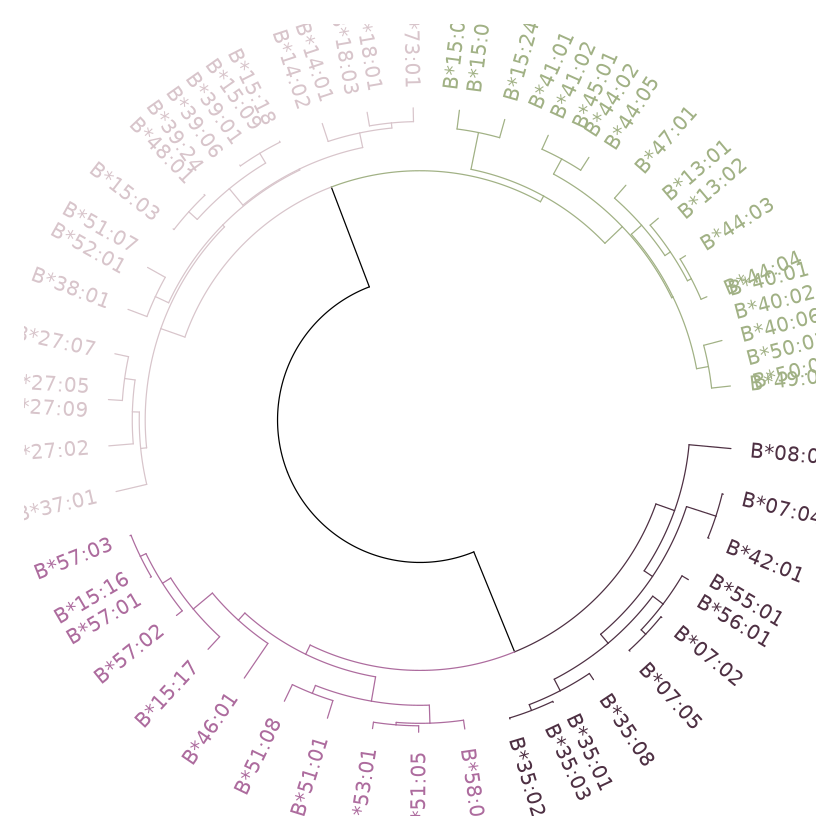

In [131]:
hclust_physchem <- hclust(physchem_distance_matrix, method = "ward.D2")


# Cut the dendrogram to define clusters (e.g., 3 clusters)
num_clusters_physchem <- 4
clusters_physchem <- cutree(hclust_physchem, k = num_clusters_physchem)

# Enhance the dendrogram with colors
dend_physchem <- as.dendrogram(hclust_physchem)
physchem_colors <- scico(num_clusters_physchem, palette = 'bamO', end = 0.6)
dend_physchem <- color_branches(dend_physchem, k = num_clusters_physchem, col = physchem_colors)
dend_physchem <- color_labels(dend_physchem, k = num_clusters_physchem, col = physchem_colors)
circlize_dendrogram(dend_physchem)

In [ ]:
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_B_circular_dendrogram_psyschem.pdf", 
    width = 12, height = 12)
circlize_dendrogram(dend_physchem)
dev.off()

agg_record_174241711 
                   2

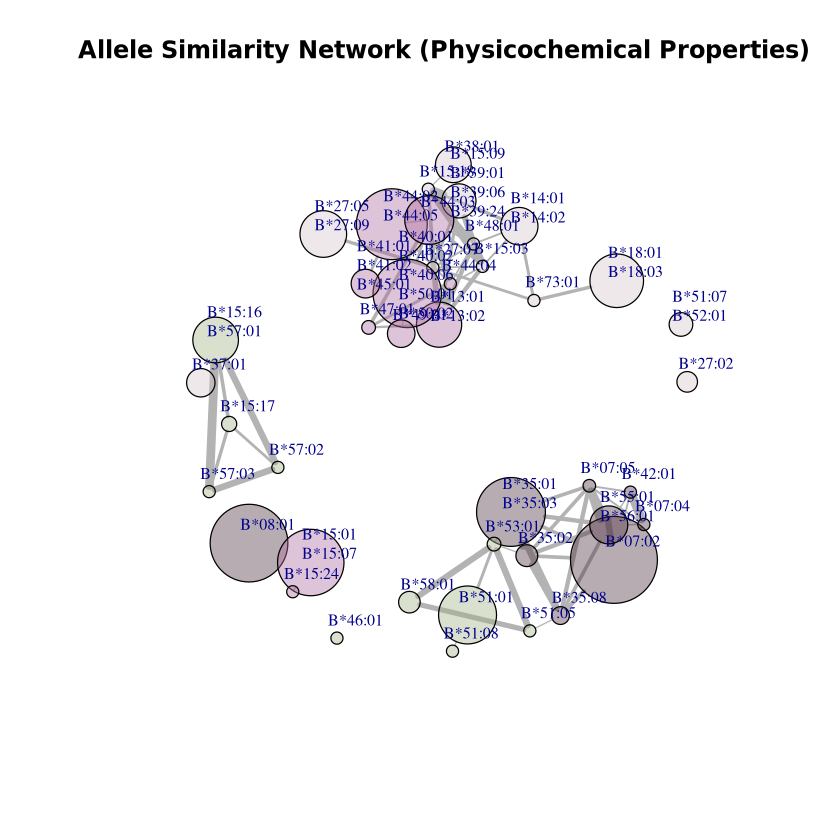

In [ ]:
physchem_threshold_for_edges <- 30 # Example threshold, adjust based on your data's distance range

edges_dt_physchem_network <- data.table(melt(physchem_distance_matrix_full))[, 
  Var1 := as.character(Var1)][,
  Var2 := as.character(Var2)][, pair := paste0(pmin(Var1,Var2), pmax(Var1,Var2))][Var1 != Var2][
  value <= physchem_threshold_for_edges][!duplicated(pair)][, pair := NULL][,
  weight:= max(value) - value + min(value)]
setnames(edges_dt_physchem_network, new =c('from', 'to'), old = c('Var1', 'Var2')) 
edges_dt_physchem_network$weight <- scales::rescale(edges_dt_physchem_network$weight, to = c(1, 7))

# Create the igraph object
g_physchem_network <- graph_from_data_frame(d = edges_dt_physchem_network,
                                            vertices = allele_ids_with_sizes,
                                            directed = FALSE)

# Add cluster membership and pattern sequences as node attributes
V(g_physchem_network)$cluster <- clusters_physchem[V(g_physchem_network)$name]
V(g_physchem_network)$pattern <- hla_var_patterns$cdr3qtl_pattern[match(V(g_physchem_network)$name, hla_var_patterns$allele)]
V(g_physchem_network)$label <- V(g_physchem_network)$name
E(g_physchem_network)$weight <- edges_dt_physchem_network$weight
# Set node colors based on cluster membership
physchem_colors <- scico(num_clusters_physchem, palette = 'bamO', end = 0.6, alpha = 0.4)
V(g_physchem_network)$color <- physchem_colors[as.numeric(V(g_physchem_network)$cluster)]
layout <- layout_with_kk(g_physchem_network, weights = E(g_physchem_network)$weight) 
#layout <- layout * 5
# Plot the network
plot(g_physchem_network,
      vertex.label = V(g_physchem_network)$label,
      vertex.label.cex = 0.8,
      vertex.label.dist = 1.5, 
      vertex.color = V(g_physchem_network)$color,
      vertex.size = ifelse(V(g_physchem_network)$size > 5, V(g_physchem_network)$size, 5),
      edge.width = E(g_physchem_network)$weight,
      edge.color = "gray70",
      layout =  layout,
      main = "Allele Similarity Network (Physicochemical Properties)")


In [158]:
write_graph(g_physchem_network, file = "/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/graphs/hla_b_graph.graphml", format = "graphml")

In [ ]:
pdf("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_b_allele_network_physchem_clusters.pdf", 
      width = 10, height = 8)
plot(g_physchem_network,
      vertex.label = V(g_physchem_network)$label,
      vertex.label.cex = 0.8,
      vertex.label.dist = 1.5, 
      vertex.color = V(g_physchem_network)$color,
      vertex.size = ifelse(V(g_physchem_network)$size > 5, V(g_physchem_network)$size, 5),
      edge.width = E(g_physchem_network)$weight,
      edge.color = "gray70",
      layout = layout_with_kk(g_physchem_network, weights = E(g_physchem_network)$weight),
      main = "Allele Similarity Network (Physicochemical Properties)")
dev.off()

agg_record_806396988 
                   2

## Building seqlogo of public clones for each HLA alleles

In [1]:
library(data.table)

In [4]:
hla_clones <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/fisher_clone_hla.tsv')[,
    c('amino_acid', 'v_gene', 'j_gene') := tstrsplit(clone, '_', fixed = TRUE)]#[, 
    #v_gene := gsub('0', '', gsub('C', '', v_gene))][, 
    #j_gene := gsub('0', '', gsub('C', '', j_gene))]
hla_clones_sig <- hla_clones[, p_adj := p.adjust(p_val, method = "bonferroni")][p_adj < 0.05]

In [ ]:
hla_clones_sig_clones <- split(hla_clones_sig, by = 'allele')


In [10]:
phenotypes <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/phenotypes.tsv')
cdr3_summary <- merge(fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/summary_cdr3_dt.tsv'), 
    phenotypes, by = 'patient_id', all.x = TRUE)
    hla <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/hla_features.tsv')[
    gene %in% c('B', 'DRB1')][patient_id %in% cdr3_summary$patient_id]

hlas <- dcast(hla, patient_id ~ allele, value.var = 'homo_hetero', fun.aggregate = sum, fill = 0)
data.frame(n_car = colSums(hlas[,-1])) %>% filter(n_car>30) %>% rownames() %>% uniqueN()

[1] 40

In [ ]:
1286800000

[1] 1286800000

In [6]:
uniqueN(hla_clones_sig$allele)

[1] 29

In [23]:
fwrite(hla_clones_sig[, .(allele, clone, p_adj)][order(allele)], 
       file = '/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/fisher_clone_hla_sig.tsv', 
       sep = '\t', quote = FALSE, row.names = FALSE)

In [12]:
for (i in seq_along(hla_clones_sig_clones)) {
    test_logo <- hla_clones_sig_clones[[i]]$amino_acid
    al <- hla_clones_sig_clones[[i]]$allele[1]
    max_l <- max(nchar(test_logo))
    logo_matrix <- unlist(lapply(test_logo, function(a) align_imgt(a, max_l)))
    
    logo_pl <- ggseqlogo::ggseqlogo(logo_matrix, method = 'prob', seq_type = 'aa') +
     ggtitle(al) 
    ggsave(filename = paste0('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_clone_seqlogos/hla_drb1_', al, '_logo_cluster.pdf'), 
           plot = logo_pl, width = 10, height = 5)
    
}

## Seqlogos for each HLA cluster

In [23]:
cluster_labels <- clusters_physchem

In [ ]:
clusters_physchem[clusters_physchem ==1] <- 'Cluster1 HLA-DRB1'
clusters_physchem[clusters_physchem ==2] <- 'Cluster2 HLA-DRB1'
clusters_physchem[clusters_physchem ==3] <- 'Cluster3 HLA-DRB1'
clusters_physchem[clusters_physchem ==4] <- 'Cluster4 HLA-DRB1'

In [29]:
hla_clones_with_clusters <- hla_clones[, cluster := sapply(allele, function(x) clusters_physchem[x])]

In [30]:
hla_clones_with_clusters <- na.omit(hla_clones_with_clusters)

In [31]:
hla_split <- split(hla_clones, by = 'cluster')

In [32]:
library(ggseqlogo)

In [9]:
align_imgt <- function(CDR3, max_length = 18) {
    AA <- unlist(strsplit(CDR3, ""));
    N_AA_fow <- nchar(CDR3) %/% 2 + nchar(CDR3) %% 2;
    N_AA_na <- max_length - nchar(CDR3);
    AAmod <- c(
        AA[1:(N_AA_fow)],
        rep("-",N_AA_na),
        AA[(N_AA_fow + 1):nchar(CDR3)]
    );
    return(paste0(AAmod, collapse = ''))

}

In [34]:
for (i in seq_along(hla_split)) {
    test_logo <- hla_split[[i]]$amino_acid
    cl <- hla_split[[i]]$cluster[1]
    al <- paste0(unique(hla_split[[i]]$allele), collapse = '\n')
    max_l <- max(nchar(test_logo))
    logo_matrix <- unlist(lapply(test_logo, function(a) align_imgt(a, max_l)))
    
    logo_pl <- ggseqlogo::ggseqlogo(logo_matrix, method = 'prob', seq_type = 'aa') +
     ggtitle(al) 
    ggsave(filename = paste0('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_clone_seqlogos/hla_drb1_', cl, '_logo_cluster.pdf'), 
           plot = logo_pl, width = 10, height = 5)
    
}


## What those public clones bind

In [4]:
install.packages('ggVennDiagram')
library(ggVennDiagram)

also installing the dependencies ‘gridGraphics’, ‘ggfun’, ‘ggplotify’, ‘admisc’, ‘aplot’, ‘venn’, ‘yulab.utils’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘ggVennDiagram’


The following object is masked from ‘package:tidyr’:

    unite




In [83]:
cols <- c('CDR3', 'V','J','MHC A', 'MHC B', 'Epitope', 'Epitope species')
vdjdb <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/reference_data/SearchTable-2025-07-26_all_cdr3.tsv')[Gene == 'TRB'][,
    ..cols][, c('V', 'V-rest') := tstrsplit(V, '*', fixed = TRUE)][, 
    c('J', 'J-rest') := tstrsplit(J, '*', fixed = TRUE)]
colnames(vdjdb)[1:7] <- gsub(' ', '_', cols)

In [100]:
epitopes <- vdjdb[, .(N_clones = .N), by = Epitope_species]
epitopes <- epitopes[order(epitopes$N_clones, decreasing = TRUE)]
epitopes_order <- epitopes$Epitope_species

In [109]:
head(vdjdb)
pl <- ggplot(epitopes, aes(x = factor(Epitope_species, levels = epitopes_order), y = N_clones)) + 
geom_col() + 
theme_cowplot() + 
labs(x = 'Epitope species', y = 'Number of clones from VDJdb') +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) 
ggsave(filename = '/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/vdjdb_epitopes.pdf', pl,
       width = 12, height = 10)

CDR3,V,J,MHC_A,MHC_B,Epitope,Epitope_species,V-rest,J-rest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CASSIVGGNEQFF,TRBV19,TRBJ2-1,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSMRSTGELFF,TRBV19,TRBJ2-2,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSIRSAWAQYF,TRBV19,TRBJ2-3,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSQRSTGELFF,TRBV19,TRBJ2-2,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSIRSSYEQYF,TRBV19,TRBJ2-7,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSFDGVYEQYF,TRBV19,TRBJ2-7,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01


In [76]:
match_hla_clone_to_vdjdb <- merge(hla_clones, vdjdb, by.x = c('amino_acid','j_gene'), by.y = c('CDR3','J'))

In [77]:
match_hla_clone_to_vdjdb

amino_acid,j_gene,clone,allele,p_val,v_gene,V,MHC A,MHC B,Epitope,Epitope species,V-rest,J-rest
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CASSDSNTGELFF,TRBJ2-2,CASSDSNTGELFF_TCRBV06-04_TCRBJ02-02,DRB1*04:03,3.279500e-09,TRBV6-4,TRBV6-4,HLA-A*03:01,B2M,KLGGALQAK,CMV,01,01
CASSDSSTDTQYF,TRBJ2-3,CASSDSSTDTQYF_TCRBV06-04_TCRBJ02-03,DRB1*16:01,1.087484e-09,TRBV6-4,TRBV6-4,HLA-A*02:01,B2M,GLCTLVAML,EBV,01,01
CASSDSSTDTQYF,TRBJ2-3,CASSDSSTDTQYF_TCRBV06-04_TCRBJ02-03,DRB1*16:01,1.087484e-09,TRBV6-4,TRBV6-4,HLA-A*11:01,B2M,AVFDRKSDAK,EBV,01,01
CASSIGTDTQYF,TRBJ2-3,CASSIGTDTQYF_TCRBV19-01_TCRBJ02-03,B*38:01,7.885753e-10,TRBV19-1,TRBV19,HLA-A*02:01,B2M,GILGFVFTL,InfluenzaA,01,01
CASSLGGYEQYF,TRBJ2-7,CASSLGGYEQYF_TCRBV11-02_TCRBJ02-07,DRB1*13:01,2.285049e-08,TRBV11-2,TRBV7-2,HLA-A*02:01,B2M,GLCTLVAML,EBV,01,01
CASSLGNTEAFF,TRBJ1-1,CASSLGNTEAFF_TCRBV05-05_TCRBJ01-01,B*14:02,1.984699e-08,TRBV5-5,TRBV6-2,HLA-A*02:01,B2M,GLCTLVAML,EBV,01,01
CASSLGNTEAFF,TRBJ1-1,CASSLGNTEAFF_TCRBV05-05_TCRBJ01-01,B*14:02,1.984699e-08,TRBV5-5,TRBV6-2,HLA-A*02:01,B2M,GLCTLVAML,EBV,01,01
CASSLGNTEAFF,TRBJ1-1,CASSLGNTEAFF_TCRBV05-05_TCRBJ01-01,B*14:02,1.984699e-08,TRBV5-5,TRBV6-3,HLA-A*02:01,B2M,GLCTLVAML,EBV,01,01
CASSLGNTEAFF,TRBJ1-1,CASSLGNTEAFF_TCRBV05-05_TCRBJ01-01,B*14:02,1.984699e-08,TRBV5-5,TRBV7-2,HLA-A*11:01,B2M,AVFDRKSDAK,EBV,01,01


## Association between HLA alleles and public clones

In [2]:
fisher_hla_clones <- fread('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/fisher_clone_hla.tsv')

In [7]:
split(fisher_hla_clones[p_val < 0.0001], by = 'allele')

clone,allele,p_val
<chr>,<chr>,<dbl>
CASSDSSTDTQYF_TCRBV06-04_TCRBJ02-03,DRB1*16:01,1.087484e-09
CASSPGQGNQPQHF_TCRBV12_TCRBJ01-05,DRB1*16:01,5.791879e-13
CASSDSSGGADTQYF_TCRBV06-04_TCRBJ02-03,DRB1*16:01,2.236645e-08
CASSGTSTDTQYF_TCRBV06-04_TCRBJ02-03,DRB1*16:01,2.039739e-05
CASSQGYGYTF_TCRBV03-01_TCRBJ01-02,DRB1*16:01,3.420798e-05
CASSSGGSNQPQHF_TCRBV28-01_TCRBJ01-05,DRB1*16:01,1.243030e-05
CASSFSTDTQYF_TCRBV07-02_TCRBJ02-03,DRB1*16:01,2.112582e-06
CASSLKGNTEAFF_TCRBV12-03_TCRBJ01-01,DRB1*16:01,2.849729e-10
CSARVGQETQYF_TCRBV20_TCRBJ02-05,DRB1*16:01,5.303314e-05
